In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
from tensorflow.keras.layers import Normalization, Dense, InputLayer
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

data = pd.read_csv('train.csv', ",")
data.head()

# sns.pairplot(data[['years', 'km', 'rating', 'condition', 'economy', 'top speed', 'hp', 'torque', 'current price']], diag_kind='kde')

# prep data
tensor_data = tf.constant(data)
tensor_data = tf.cast(tensor_data, tf.float32)
tensor_data = tf.random.shuffle(tensor_data)

X, Y = tensor_data[:, 3:-1], tensor_data[:, -1]
Y = tf.expand_dims(Y, axis=-1)


2024-05-10 19:52:13.204093: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/imagry/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)
2024-05-10 19:52:15.318296: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
normalizer = Normalization()
normalizer.adapt(X)
normalizer(X)

<tf.Tensor: shape=(1000, 8), dtype=float32, numpy=
array([[ 0.25549713, -0.5147744 ,  1.4350005 , ..., -0.5131564 ,
        -0.02662536, -1.1603376 ],
       [ 0.25549713,  0.77916265,  1.4350005 , ...,  0.62799746,
         0.9974312 , -1.3503778 ],
       [-0.32650068, -0.58019197, -0.7046622 , ..., -0.3056739 ,
         0.8023728 ,  0.7875741 ],
       ...,
       [-0.9084985 , -1.0085983 ,  0.00855871, ...,  1.1467037 ,
         0.21719764,  0.2649637 ],
       [ 0.25549713, -1.3736122 ,  1.4350005 , ...,  0.31677365,
         0.65607905, -0.06760663],
       [ 0.8374949 ,  1.7033151 ,  0.72177964, ...,  1.4060569 ,
         1.6801356 ,  1.6902649 ]], dtype=float32)>

In [45]:
model=tf.keras.Sequential([
    InputLayer(shape=(8,)),
    normalizer,
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1),
])
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 8)              │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,322 (134.07 KB)

 Trainable params: 34,305 (134.00 KB)

 Non-trainable params: 17 (72.00 B)

In [48]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 310734.2188 - root_mean_squared_error: 334580.4062


[308520.125, 333261.5]

In [49]:
model.compile(optimizer=Adam(learning_rate=0.1),loss = MeanAbsoluteError(), metrics=[RootMeanSquaredError()])
model.evaluate(X, Y)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 310734.2188 - root_mean_squared_error: 334580.4062


[308520.125, 333261.5]

In [7]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
DATASET_SIZE = len(X)

In [56]:
# training data
X_train = X[:int(DATASET_SIZE * TRAIN_RATIO)]
Y_train = Y[:int(DATASET_SIZE * TRAIN_RATIO)]
print(X_train.shape, Y_train.shape)

(800, 8) (800, 1)


In [72]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [59]:
for x,y in train_dataset:
    print(x,y)
    break

tf.Tensor(
[[3.00000e+00 5.24980e+04 1.00000e+00 5.00000e+00 1.20000e+01 1.37000e+02
  7.90000e+01 9.50000e+01]
 [3.00000e+00 6.52930e+04 4.00000e+00 4.00000e+00 1.00000e+01 1.93000e+02
  1.05000e+02 6.90000e+01]
 [7.00000e+00 1.42292e+05 4.00000e+00 1.00000e+00 1.20000e+01 1.35000e+02
  7.50000e+01 1.09000e+02]
 [7.00000e+00 6.14780e+04 4.00000e+00 5.00000e+00 8.00000e+00 1.61000e+02
  5.50000e+01 7.50000e+01]
 [4.00000e+00 1.30980e+05 1.00000e+00 3.00000e+00 1.20000e+01 2.00000e+02
  5.60000e+01 9.30000e+01]
 [5.00000e+00 9.70130e+04 3.00000e+00 3.00000e+00 1.50000e+01 1.80000e+02
  9.90000e+01 1.00000e+02]
 [4.00000e+00 7.94290e+04 3.00000e+00 6.00000e+00 1.40000e+01 1.70000e+02
  7.60000e+01 9.20000e+01]
 [2.00000e+00 6.57060e+04 4.00000e+00 1.00000e+01 8.00000e+00 1.48000e+02
  8.40000e+01 7.50000e+01]
 [5.00000e+00 1.07869e+05 4.00000e+00 1.00000e+00 9.00000e+00 1.65000e+02
  7.40000e+01 8.50000e+01]
 [7.00000e+00 1.03849e+05 2.00000e+00 1.00000e+01 1.50000e+01 1.50000e+02
  9.90

In [73]:
#validation data
X_val = X[int(DATASET_SIZE * TRAIN_RATIO):int(DATASET_SIZE * (TRAIN_RATIO + VAL_RATIO))]
Y_val = Y[int(DATASET_SIZE * TRAIN_RATIO):int(DATASET_SIZE * (TRAIN_RATIO + VAL_RATIO))]
print(X_val.shape, Y_val.shape)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

(100, 8) (100, 1)


In [74]:
# testing data
X_test = X[int(DATASET_SIZE * (TRAIN_RATIO + VAL_RATIO)):]
Y_test = Y[int(DATASET_SIZE * (TRAIN_RATIO + VAL_RATIO)):]
print(X_test.shape, Y_test.shape)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_dataset = test_dataset.shuffle(buffer_size=1024, reshuffle_each_iteration=True)
test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

(100, 8) (100, 1)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [75]:
normalizer = Normalization()
normalizer.adapt(X_train)
normalizer(X_train)

<tf.Tensor: shape=(800, 8), dtype=float32, numpy=
array([[ 0.2355255 , -0.51052296,  1.3972702 , ..., -0.51699114,
        -0.02665798, -1.1966462 ],
       [ 0.2355255 ,  0.79434466,  1.3972702 , ...,  0.6314433 ,
         1.0052574 , -1.3884165 ],
       [-0.3496308 , -0.5764932 , -0.73190343, ..., -0.30818486,
         0.808702  ,  0.76899874],
       ...,
       [-0.93478715,  0.03253733, -1.441628  , ..., -0.51699114,
         0.41559142, -1.1487037 ],
       [-1.5199435 ,  1.4068711 ,  0.68754566, ..., -0.7257974 ,
        -0.56718504, -0.86104834],
       [-0.3496308 ,  1.2303851 ,  0.68754566, ..., -0.5691927 ,
        -0.9111568 ,  0.09780287]], dtype=float32)>

In [76]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=1)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27472.4902 - root_mean_squared_error: 34909.7891 - val_loss: 43055.9961 - val_root_mean_squared_error: 51547.4922
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25284.6133 - root_mean_squared_error: 32769.4453 - val_loss: 44429.7695 - val_root_mean_squared_error: 53966.4922
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29754.2949 - root_mean_squared_error: 38340.6875 - val_loss: 42143.2500 - val_root_mean_squared_error: 51092.7773
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28947.8516 - root_mean_squared_error: 36921.8867 - val_loss: 46685.0000 - val_root_mean_squared_error: 56183.1758
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 28222.2207 - root_mean_squared_error: 36008.2109 - val_loss: 47358.9141 - val_root_mean_squared_error: 56645.0586
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29235.0605 - root_mean_squared_error: 37201.2734 - val_loss: 40909.5312 - 

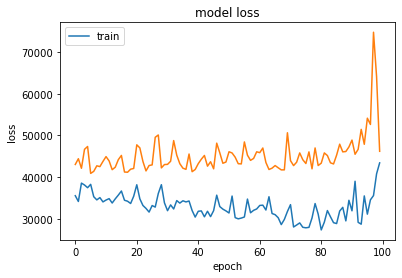

In [77]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [53]:
model.evaluate(X_test, Y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 45911.7617 - root_mean_squared_error: 54898.3477 


[46349.44140625, 54934.93359375]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


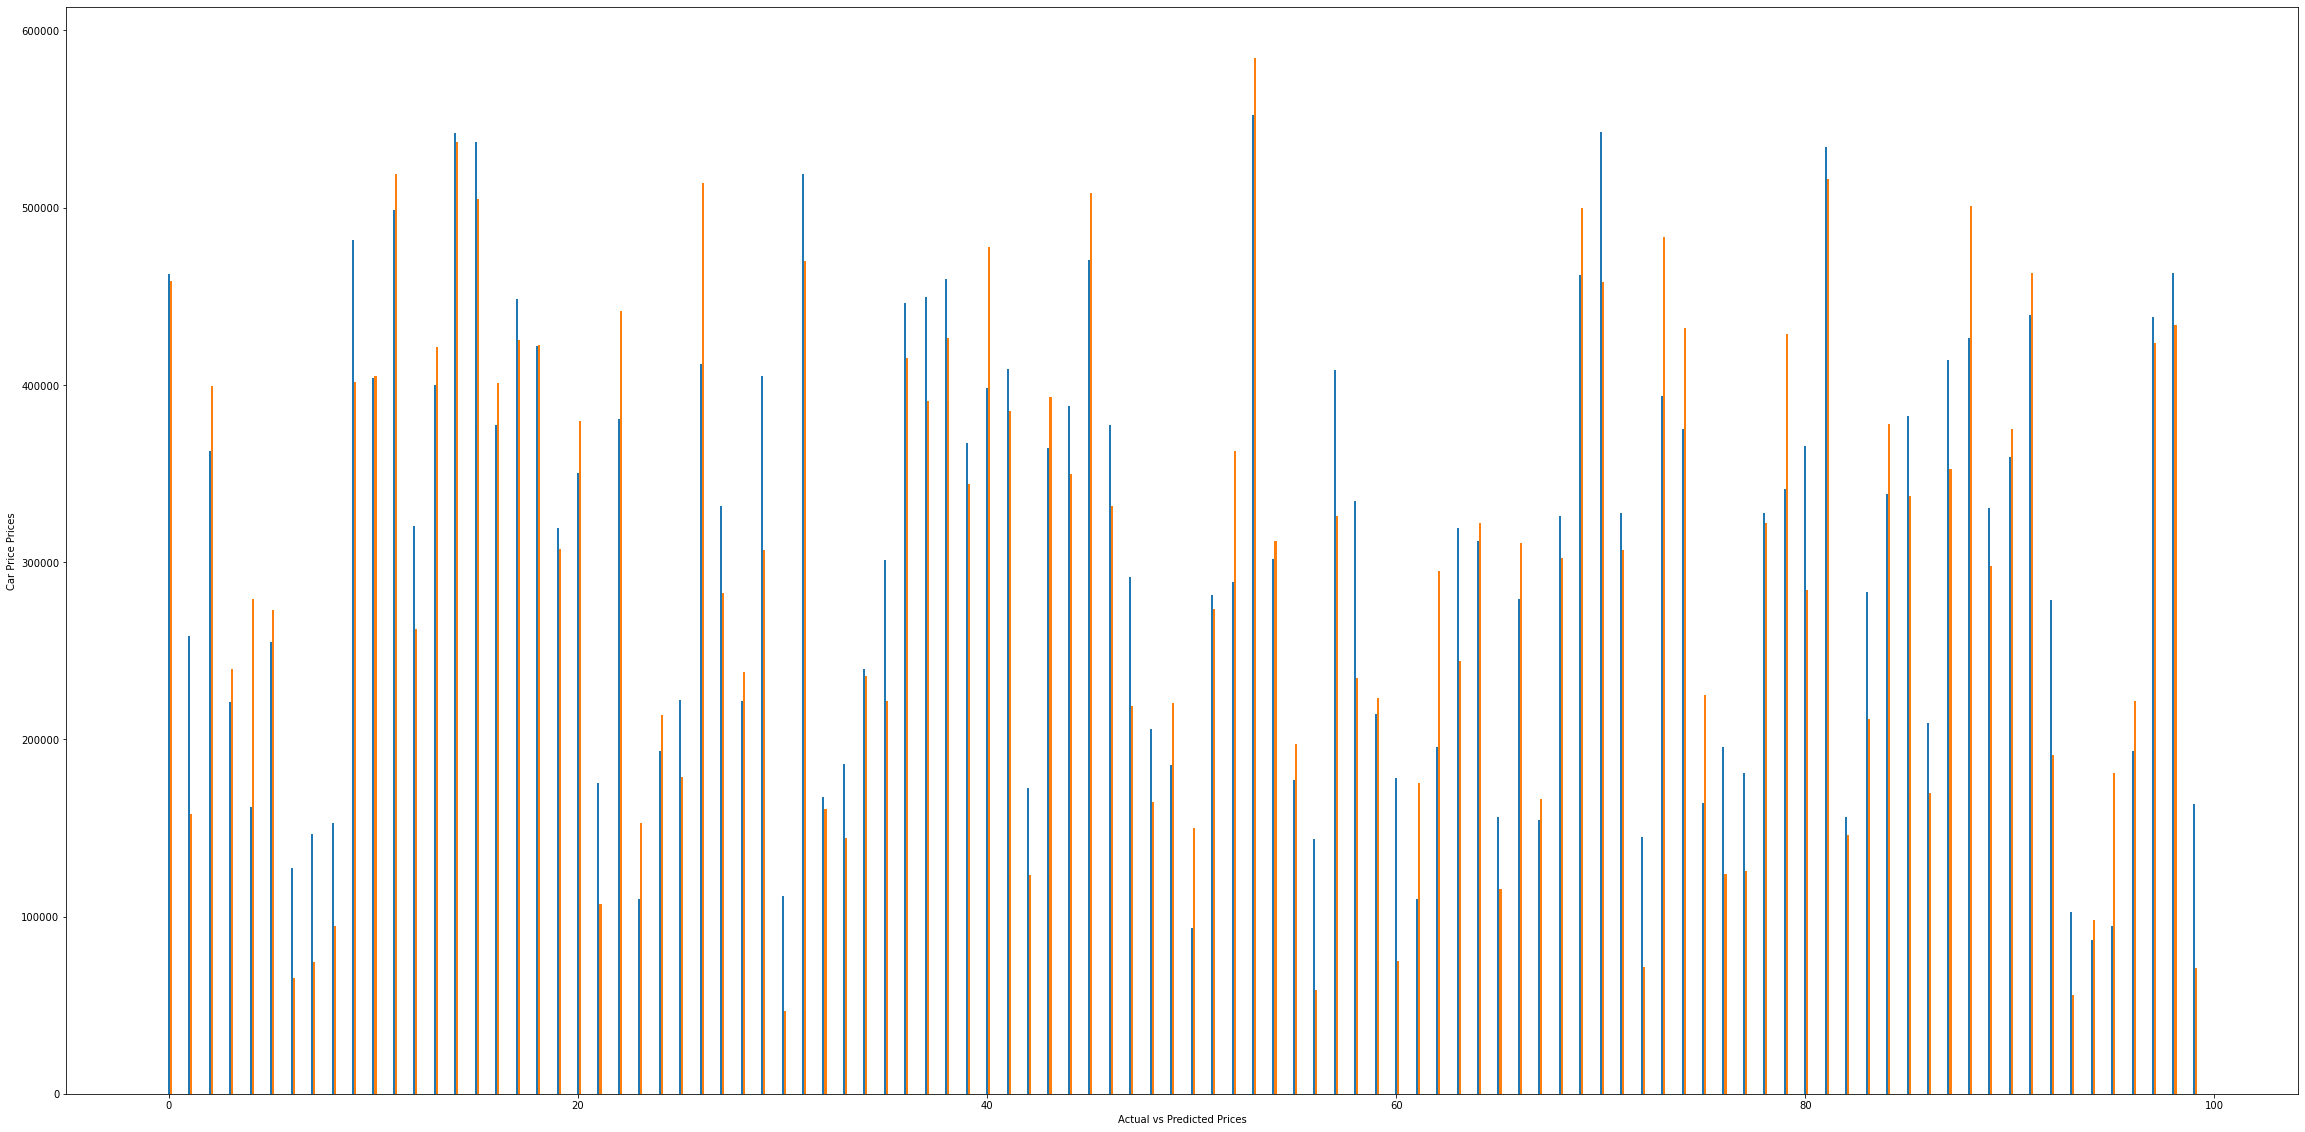

In [55]:
y_true = list(Y_test[:,0].numpy())
y_pred = list(model.predict(X_test)[:,0])
ind = np.arange(100)
plt.figure(figsize=(40,20))

width = 0.1

plt.bar(ind, y_pred, width, label='Predicted Car Price')
plt.bar(ind + width, y_true, width, label='Actual Car Price')

plt.xlabel('Actual vs Predicted Prices')
plt.ylabel('Car Price Prices')

plt.show()